# Imports

In [1]:
import sys
import os

import numpy as np
from sklearnex import patch_sklearn

patch_sklearn()

import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.model_selection import LeaveOneGroupOut
from joblib import Parallel, delayed

from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, average_precision_score, f1_score, \
    recall_score, precision_score, matthews_corrcoef, roc_curve, roc_auc_score

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Config and feature selection

In [2]:
pipe_lasso = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(penalty='l1', solver='saga', class_weight='balanced'))
])

num_cores = 30
window_length = 60

In [3]:
# Our initial pipeline calculated more than the features we used in the paper. This is reducing the feature set.

base_features = [
    'gaze+{}_x',
    'gaze+{}_y',
    'gaze+{}_a_x',
    'gaze+{}_v_x',
    'gaze+{}_a_y',
    'gaze+{}_v_y',
    'gaze+{}_a_x_y',
    'gaze+{}_v_x_y',
    'head+{}_v_head_x',
    'head+{}_a_head_x',
    'head+{}_v_head_y',
    'head+{}_a_head_y',
    'head+{}_v_head_z',
    'head+{}_a_head_z',
    'head+{}_v_head_x_y_z',
    'head+{}_a_head_x_y_z',
    'fixation+{}_duration',
    'fixation+{}_amp',
    'fixation+{}_peak_vel',
    'fixation+{}_avg_vel',
    'fixation+count',
    'saccades+{}_duration',
    'saccades+{}_amp',
    'saccades+{}_peak_vel',
    'saccades+{}_avg_vel',
    'saccades+count'
]

core_features = []
for f in base_features:
    if ("saccade" in f or "fixation" in f) and "_duration" in f:
        for calc in ["mean", "std", "skewness", "kurtosis", "power", "q5", "q95"]:
            core_features.append(f.format(calc))
    elif f == "gaze+{}_x" or f == "gaze+{}_y":
        for calc in ["mean", "std", "skewness", "kurtosis", "power", "q5", "q95"]:
            core_features.append(f.format(calc))
    elif "{}" in f:
        for calc in ["mean", "std", "skewness", "kurtosis", "power", "q5", "q95"]:
            core_features.append(f.format(calc))
    else:
        core_features.append(f)

print("Total number features:", len(core_features))

Total number features: 170


# Read data

In [4]:
match_state_label = {"sober": 0, "below": 1, "above": 2} # or no_alcohol, moderate, severe

def read_eye_tracking_data(window_length):
    data = pd.read_parquet(
        '/adar/drive/calculated/eye_tracking_features/calc_all_participants_{}s.parquet'.format(window_length))
    return data

def prepare_data(data, replace_below="sober"):
    data_copy = data.copy()

    y_original = data["state"].copy()
    data_copy["state"] = data_copy["state"].replace("below", replace_below)
    print(f"Keep below windows, replaced below with {replace_below}")

    for state in match_state_label:
        data_copy.loc[data_copy["state"] == state, 'label'] = match_state_label[state]
        y_original = y_original.replace(state, match_state_label[state])

    data_copy.loc[data_copy["label"] > 1, 'label'] = 1

    data_copy = data_copy.drop(["state"], axis=1)

    drivers_column = data_copy["id"]

    if "scenario" in data_copy.columns:
        x, y, scenario = data_copy.drop(["id", "label", "scenario"], axis=1), data_copy["label"], data_copy["scenario"]
        return x, y, scenario, drivers_column, y_original
    else:
        x, y = data_copy.drop(["id", "label"], axis=1), data_copy["label"]
        return x, y, drivers_column, y_original

In [5]:
data = read_eye_tracking_data(window_length)
data = data[data["id"] != "d-019"]  # user with erroneous eye tracking data

print("Amount feature vectors:", len(data))
print("Amount features:", len(data.columns))
data

Amount feature vectors: 159645
Amount features: 1161


,num_samples,gaze+mean_x,gaze+median_x,gaze+std_x,gaze+min_x,gaze+q5_x,gaze+max_x,gaze+q95_x,gaze+range_x,gaze+iqrange_x,...,blink+power_duration,blink+skewness_duration,blink+kurtosis_duration,blink+rms_duration,blink+lineintegral_duration,blink+iqrange_5_95_duration,blink+count,state,scenario,id
datetime,,,,,,,,,,,,,,,,,,,,,
2021-08-27 07:46:15,3458,890.277857,844.033725,437.014132,-228.662682,383.043894,2265.301208,2043.559340,2493.963890,332.638854,...,0.121355,2.048715,3.567861,0.348360,7.006,0.80320,33,sober,town,d-001
2021-08-27 07:46:16,3458,899.266304,847.851382,434.994753,-228.662682,383.043894,2265.301208,2043.559340,2493.963890,338.432262,...,0.121355,2.048715,3.567861,0.348360,7.006,0.80320,33,sober,town,d-001
2021-08-27 07:46:17,3458,906.179795,850.390929,432.845452,-228.662682,383.043894,2265.301208,2043.559340,2493.963890,345.006726,...,0.117786,2.085313,3.747497,0.343199,8.039,0.78405,34,sober,town,d-001
2021-08-27 07:46:18,3458,911.679225,855.891816,431.291361,-228.662682,383.043894,2265.301208,2043.559340,2493.963890,341.847510,...,0.117786,2.085313,3.747497,0.343199,8.039,0.78405,34,sober,town,d-001
2021-08-27 07:46:19,3458,912.893608,854.434523,429.742776,-228.662682,383.043894,2265.301208,2043.559340,2493.963890,328.557414,...,0.117786,2.085313,3.747497,0.343199,8.039,0.78405,34,sober,town,d-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 13:51:12,3439,1037.480080,982.929292,450.998558,-297.323856,296.881022,2290.018616,2018.848225,2587.342472,488.865071,...,0.121243,1.551129,1.721039,0.348200,7.393,0.74350,24,below,town,d-035
2021-11-10 13:51:13,3460,1018.848215,967.660466,436.774792,-297.323856,297.636209,2290.018616,1779.050083,2587.342472,494.258758,...,0.121543,1.637292,1.914952,0.348630,6.695,0.75850,22,below,town,d-035
2021-11-10 13:51:14,3460,1003.115731,966.056977,413.530496,-297.323856,297.636209,2290.018616,1599.238685,2587.342472,494.007780,...,0.131218,1.525060,1.441725,0.362240,5.961,0.77935,20,below,town,d-035


In [6]:
print("Number of drivers:", len(data["id"].unique()))
print("Names of drivers:", data["id"].unique())
print("Number of scenarios:", len(data["scenario"].unique()))
print("Names of scenarios:", data["scenario"].unique())
print("Number of states:", len(data["state"].unique()))
print("Names of states:", data["state"].unique())

Number of drivers: 30
Names of drivers: ['d-001' 'd-002' 'd-003' 'd-004' 'd-005' 'd-006' 'd-007' 'd-008' 'd-010'
 'd-011' 'd-012' 'd-013' 'd-014' 'd-015' 'd-016' 'd-017' 'd-018' 'd-020'
 'd-021' 'd-023' 'd-024' 'd-025' 'd-026' 'd-029' 'd-030' 'd-031' 'd-032'
 'd-033' 'd-034' 'd-035']
Number of scenarios: 3
Names of scenarios: ['town' 'highway' 'rural']
Number of states: 3
Names of states: ['sober' 'above' 'below']


In [7]:
datasets = {}
for model_name in ["Early Warning", "Above Limit"]:
    print(model_name)
    if "Early Warning" in model_name:
        replace_below = "above"
    else:
        replace_below = "sober"
    x, y, scenario, user_ids, y_orig = prepare_data(data, replace_below=replace_below)
    x = x[core_features]
    datasets[model_name] = {"x": x, "y": y, "scenario": scenario, "user_ids": user_ids, "y_orig": y_orig}

Early Warning
Keep below windows, replaced below with above
[]
Above Limit
Keep below windows, replaced below with sober
[]


# Prediction

In [8]:
LOGO = LeaveOneGroupOut()
SCORING = {'ROC AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
           "Balanced Accuracy": make_scorer(balanced_accuracy_score), "F1": make_scorer(f1_score),
           "PRC AUC": make_scorer(average_precision_score, needs_proba=True),
           "Recall": make_scorer(recall_score), "Precision": make_scorer(precision_score),
           "MCC": make_scorer(matthews_corrcoef)}

def get_proba_scores(clf, X, y, groups, n_jobs):
    def predict_proba(clf, group):
        X_train = X[groups != group]
        y_train = y[groups != group]
        X_test = X[groups == group]

        clf_fitted = clf.fit(X_train, y_train)
        y_pred_train = clf_fitted.predict(X_train)
        y_pred_proba_test = clf_fitted.predict_proba(X_test)[:, 1]

        coef = pd.DataFrame({"Feature": X_train.columns.tolist(), "Coefficients": clf_fitted["clf"].coef_[0]})
        return {group: {"y_pred_proba_test": y_pred_proba_test, "coef": coef}}

    with Parallel(n_jobs=n_jobs, verbose=10) as parallel:
        results = parallel(delayed(predict_proba)(clone(clf), group) for group in np.unique(groups))
    results = {k: v for d in results for k, v in d.items()}

    y_pred_proba_test = []
    coefs = {}
    for group in sorted(results.keys()):
        y_pred_proba_test.extend(list(results[group]["y_pred_proba_test"]))
        coefs[group] = results[group]["coef"]

    return np.array(y_pred_proba_test), coefs

def get_prediction_results(name, y_true, y_pred_proba, y_orig, groups, scenarios, features, window_size, coeffs):
    all_results = dict()
    for group in np.unique(groups):
        y_min_class = 0
        y_max_class = 1
        y_pred = np.where(y_pred_proba < 0.5, y_min_class, y_max_class)

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true[group == groups],
                                                                        y_pred_proba[group == groups])

        results = dict()
        results["y_true"] = y_true[group == groups]
        results["y_pred_proba"] = y_pred_proba[group == groups]
        results["y_pred"] = y_pred[group == groups]
        results["y_orig"] = y_orig[group == groups]
        results["scenario"] = scenarios[group == groups]
        results["coefs"] = coeffs[group]

        all_results[group] = results

    all_results["features"] = features
    all_results["name"] = name
    all_results["window_size"] = window_size

    return all_results

In [9]:
result_dfs = {}
for model in ["Early Warning", "Above Limit"]:        
    x = datasets[model]["x"]
    y = datasets[model]["y"]
    scenario = datasets[model]["scenario"]
    user_ids = datasets[model]["user_ids"]
    y_orig = datasets[model]["y_orig"]
    
    y_pred_proba, coefs = get_proba_scores(pipe_lasso, x[core_features], y,
                                                            groups=user_ids,
                                                            n_jobs=num_cores)
    
    result_dfs[model] = get_prediction_results(model_name, np.array(y), y_pred_proba, y_orig, user_ids,
                                             scenario, core_features, window_length, coefs)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   3 out of  30 | elapsed:   46.1s remaining:  6.9min
[Parallel(n_jobs=30)]: Done   7 out of  30 | elapsed:   46.4s remaining:  2.5min
[Parallel(n_jobs=30)]: Done  11 out of  30 | elapsed:   47.0s remaining:  1.4min
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:   47.7s remaining:   47.7s
[Parallel(n_jobs=30)]: Done  19 out of  30 | elapsed:   48.1s remaining:   27.8s
[Parallel(n_jobs=30)]: Done  23 out of  30 | elapsed:   48.4s remaining:   14.7s
[Parallel(n_jobs=30)]: Done  27 out of  30 | elapsed:   48.6s remaining:    5.4s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:   49.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   3 out of  30 | elapsed:   44.2s remaining:  6.6min
[Parallel(n_jobs=30)]: Done   7 out of  30 | elapsed:   44.4s remaining:  2.4min
[Parallel(n_jobs=30)]: Done  11 out of  30 | e

# Results

In [10]:
scores = {"auroc": roc_auc_score, "prcauc": average_precision_score, "b_acc": balanced_accuracy_score,
          "acc": accuracy_score, "f1_weighted": f1_score, "recall": recall_score, "precision": precision_score,
          "mcc": matthews_corrcoef}

def __create_f1_score(results, name, score_func, y_true, y_pred):
    results[name].append(score_func(y_true, y_pred, average="weighted"))
    return results

def summarize_results(all_results, by="driver", choices=["y_pred"]):
    results = dict()

    for choice in choices:
        for score in scores.keys():
            if by == "driver":
                results[choice + "_" + score] = []
            elif by == "scenario":
                scenarios = None
                for key in all_results.keys():
                    if "d-" in key:
                        scenarios = all_results[key]["scenario"]
                        break
                if scenarios is None:
                    print("No scenarions found")
                    return
                for scenario in np.unique(scenarios):
                    results[choice + "_" + scenario + "_" + score] = []
            else:
                print("Please specifiy 'by' either as driver or scenario")
                return
            results["driver"] = []

    for key in all_results.keys():
        if "d-" not in key:
            continue
        results["driver"].append(key)
        y_true = all_results[key]["y_true"]

        y_pred_proba = all_results[key]["y_pred_proba"]

        for choice in choices:
            if by == "driver":
                for score in scores:
                    if score == "auroc" or score == "prcauc":
                        results[choice + "_" + score].append(scores[score](y_true, y_pred_proba))
                    elif score == "f1_weighted":
                        results = __create_f1_score(results, choice + "_" + score, scores[score], y_true,
                                                    all_results[key][choice])
                    else:
                        results[choice + "_" + score].append(scores[score](y_true, all_results[key][choice]))

            elif by == "scenario":
                scenarios = all_results[key]["scenario"]
                for scenario in np.unique(scenarios):
                    for score in scores:
                        if score == "auroc" or score == "prcauc":
                            results[choice + "_" + scenario + "_" + score].append(
                                scores[score](y_true[scenario == scenarios],
                                              y_pred_proba[scenario == scenarios]))
                        elif score == "f1_weighted":
                            results = __create_f1_score(results, choice + "_" + scenario + "_" + score, scores[score],
                                                        y_true[scenario == scenarios],
                                                        all_results[key][choice][scenario == scenarios])
                        else:
                            results[choice + "_" + scenario + "_" + score].append(
                                scores[score](y_true[scenario == scenarios],
                                              all_results[key][choice][scenario == scenarios]))

    for key in results.keys():
        if key != "driver":
            print("{}: M {:.2f} +/- SD {:.2f}".format(key, np.mean(results[key]), np.std(results[key])))

In [11]:
for key in result_dfs:
    print("Model", key)
    summary_df = summarize_results(result_dfs[key])

Model Early Warning
y_pred_auroc: M 0.79 +/- SD 0.10
y_pred_prcauc: M 0.65 +/- SD 0.15
y_pred_b_acc: M 0.68 +/- SD 0.09
y_pred_acc: M 0.69 +/- SD 0.11
y_pred_f1_weighted: M 0.67 +/- SD 0.12
y_pred_recall: M 0.65 +/- SD 0.28
y_pred_precision: M 0.59 +/- SD 0.19
y_pred_mcc: M 0.39 +/- SD 0.17
Model Above Limit
y_pred_auroc: M 0.79 +/- SD 0.10
y_pred_prcauc: M 0.65 +/- SD 0.15
y_pred_b_acc: M 0.68 +/- SD 0.09
y_pred_acc: M 0.69 +/- SD 0.11
y_pred_f1_weighted: M 0.67 +/- SD 0.12
y_pred_recall: M 0.65 +/- SD 0.28
y_pred_precision: M 0.59 +/- SD 0.19
y_pred_mcc: M 0.39 +/- SD 0.17


In [12]:
for key in result_dfs:
    print("Model per scenario", key)
    summarize_results(result_dfs[key], by="scenario")

Model per scenario Early Warning


y_pred_highway_auroc: M 0.79 +/- SD 0.13
y_pred_rural_auroc: M 0.80 +/- SD 0.14
y_pred_town_auroc: M 0.81 +/- SD 0.10
y_pred_highway_prcauc: M 0.65 +/- SD 0.17
y_pred_rural_prcauc: M 0.67 +/- SD 0.20
y_pred_town_prcauc: M 0.67 +/- SD 0.17
y_pred_highway_b_acc: M 0.68 +/- SD 0.12
y_pred_rural_b_acc: M 0.69 +/- SD 0.10
y_pred_town_b_acc: M 0.68 +/- SD 0.10
y_pred_highway_acc: M 0.68 +/- SD 0.13
y_pred_rural_acc: M 0.70 +/- SD 0.12
y_pred_town_acc: M 0.70 +/- SD 0.11
y_pred_highway_f1_weighted: M 0.66 +/- SD 0.14
y_pred_rural_f1_weighted: M 0.68 +/- SD 0.13
y_pred_town_f1_weighted: M 0.68 +/- SD 0.12
y_pred_highway_recall: M 0.68 +/- SD 0.33
y_pred_rural_recall: M 0.65 +/- SD 0.29
y_pred_town_recall: M 0.61 +/- SD 0.31
y_pred_highway_precision: M 0.58 +/- SD 0.23
y_pred_rural_precision: M 0.60 +/- SD 0.19
y_pred_town_precision: M 0.60 +/- SD 0.22
y_pred_highway_mcc: M 0.38 +/- SD 0.23
y_pred_rural_mcc: M 0.40 +/- SD 0.19
y_pred_town_mcc: M 0.39 +/- SD 0.19
Model per scenario Above Limit


y_pred_highway_auroc: M 0.79 +/- SD 0.13
y_pred_rural_auroc: M 0.80 +/- SD 0.14
y_pred_town_auroc: M 0.81 +/- SD 0.10
y_pred_highway_prcauc: M 0.65 +/- SD 0.17
y_pred_rural_prcauc: M 0.67 +/- SD 0.20
y_pred_town_prcauc: M 0.67 +/- SD 0.17
y_pred_highway_b_acc: M 0.68 +/- SD 0.12
y_pred_rural_b_acc: M 0.69 +/- SD 0.10
y_pred_town_b_acc: M 0.68 +/- SD 0.10
y_pred_highway_acc: M 0.68 +/- SD 0.13
y_pred_rural_acc: M 0.70 +/- SD 0.12
y_pred_town_acc: M 0.70 +/- SD 0.11
y_pred_highway_f1_weighted: M 0.66 +/- SD 0.14
y_pred_rural_f1_weighted: M 0.68 +/- SD 0.13
y_pred_town_f1_weighted: M 0.68 +/- SD 0.12
y_pred_highway_recall: M 0.68 +/- SD 0.33
y_pred_rural_recall: M 0.65 +/- SD 0.29
y_pred_town_recall: M 0.61 +/- SD 0.31
y_pred_highway_precision: M 0.58 +/- SD 0.23
y_pred_rural_precision: M 0.60 +/- SD 0.19
y_pred_town_precision: M 0.60 +/- SD 0.22
y_pred_highway_mcc: M 0.38 +/- SD 0.23
y_pred_rural_mcc: M 0.40 +/- SD 0.19
y_pred_town_mcc: M 0.39 +/- SD 0.19


# Plots

In [13]:
import seaborn as sns

from sklearn import metrics
import scipy.stats as st
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

rcParams.update({
    'font.family':'sans-serif',
    'font.sans-serif':['Liberation Sans'],
    })

In [14]:
class LegendHandler(matplotlib.legend_handler.HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [1*height,1*height], color='C0')
        return [l1]
    
LABEL = 30

model_colors = {
    'Margin': 'C1',
    'Early Warning': 'C0',
    'Above Limit': 'C4'
}

scenario_colors = { 'Margin': {'highway': (253/255, 187/255, 128/255), 'rural': (242/255, 109/255, 24/255), 'town': (146/255, 46/255, 3/255)},
                   'Early Warning': { 'highway': (162/255, 203/255, 226/255), 'rural': (48/255, 128/255, 189/255), 'town': (8/255, 78/255, 151/255)},
                   'Above Limit': {'highway': (185/255, 186/255, 218/255), 'rural': (128/255, 125/255, 186/255), 'town': (68/255, 9/255, 129/255)},
}
replace_scenario = {"highway": "Highway", "rural": "Rural", "town": "Urban"}

In [15]:
def transform_data(all_results):
    y_true = []
    y_pred = []
    y_pred_proba = []
    y_orig = []
    scenarios = []
    subjects = []
    coefs = {}

    for key in all_results.keys():
        if "d-" in key:
            y_true.extend(all_results[key]["y_true"])
            y_pred.extend(all_results[key]["y_pred"])
            y_pred_proba.extend(all_results[key]["y_pred_proba"])
            scenarios.extend(all_results[key]["scenario"])
            subjects.extend([key] * len(all_results[key]["y_true"]))
            y_orig.extend(all_results[key]["y_orig"])
            coefs[key] = all_results[key]["coefs"]


    y_true = np.array(y_true)  
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)
    scenarios = np.array(scenarios)
    subjects = np.array(subjects)
    y_orig = np.array(y_orig)
    return {"y_true": y_true,"y_orig": y_orig, "y_pred": y_pred, "y_pred_proba": y_pred_proba, "scenarios": scenarios, "subjects": subjects, "coefs": coefs}

In [16]:
results = {}
models = ["Early Warning", "Above Limit"]
for model in models:
    print(model)
    results[model] = transform_data(result_dfs[model])
print([k for k in results.keys()])

Early Warning
Above Limit
['Early Warning', 'Above Limit']


In [17]:
from matplotlib.patches import Patch
def roc_plot(ax, y_true, y_pred, subjects, label, color, prominent=True, xlabel=True, ylabel=True, sd=True, chance=True):
    if chance:
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=1)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100) 
    for t_id in np.unique(subjects):
        try:
            fpr, tpr, thresh = metrics.roc_curve(y_true[subjects == t_id], 
                                                 y_pred[subjects == t_id])
            auc = metrics.roc_auc_score(y_true[subjects == t_id], 
                                        y_pred[subjects == t_id])
        except ValueError as e:
            mean_predictions = np.mean(y_pred[subjects == t_id])
            print(t_id, "has only one prediction class")
            print("class is:", 1 if mean_predictions >= 0.5 else 0)

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    
    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    #mean_auc = metrics.auc(mean_fpr, mean_tpr)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color=color, label=f'{label} (AUROC = {mean_auc:.2f}$\pm${np.std(aucs):.2f})', alpha=1 if prominent else .75, lw=2)

    # mean std area
    std_tpr = np.std(tprs, axis=0, ddof=1)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    if sd:
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.4 if prominent else .2, label=r'$\pm$1 SD')
            
    ax.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02])
    #ax.legend(loc="lower right", facecolor='white', edgecolor='black', framealpha=1, fancybox=False)

    text_color = '#000000'
    if ylabel:
        ax.set_ylabel('Sensitivity', color=text_color)
    if xlabel:
        ax.set_xlabel('1 - Specificity', color=text_color)
    #ax.tick_params(axis='x', colors=text_color)
    #ax.tick_params(axis='y', colors=text_color)
    #ax.spines['bottom'].set_color(text_color)
    #ax.spines['top'].set_color(text_color) 
    #ax.spines['right'].set_color(text_color)
    #ax.spines['left'].set_color(text_color)
    
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_aspect('equal', 'box')
    return '%.2f$\pm$%.2f' % (mean_auc, std_auc)

def plot_roc(results):
    fig, axs = plt.subplots(2, len(models), figsize=(9, 8), facecolor='white')
    plt.subplots_adjust(hspace=0.3)
    #axs = axs_plain.ravel()
    
    for row, env in enumerate(["Overall"]):
        for column, model in enumerate(models):
            ax = axs[0, column]
            
            score = roc_plot(ax, results[model]["y_true"], results[model]["y_pred_proba"], results[model]["subjects"], model, model_colors[model], prominent=True, xlabel=True, ylabel=True, sd=True)
    
            text_box = AnchoredText('AUROC      \n', prop=dict(fontsize='10'), frameon=True, loc='lower right', pad=0.38)
            plt.setp(text_box.patch, facecolor='white', edgecolor='#555555')
            ax.add_artist(text_box)

            ax.text(0.72, 0.04, score, transform=ax.transAxes, ha="left", va="bottom", fontsize=10, color=model_colors[model], zorder=10)
            ax.set_title(model)
    
    labels = []
    lines = []
    
    for index, model in enumerate(models):
        if index == 2:
            labels.append('ROC $\pm$1 SD        ')
        else:
            labels.append('')
        lines.append(Patch(facecolor=model_colors[model], edgecolor='black'))
    
    labels.append('Chance')
    lines.append(matplotlib.lines.Line2D([0], [0], linestyle='--', lw=2, color='grey', alpha=1))

    #axs[0, 1].legend(handles=lines, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.25), ncol=len(lines), handler_map={object: LegendHandler()}, handletextpad=0.5, handlelength=1.0, columnspacing=-0.5, )# 

    # ENVIRONMENT PLOTS
    for idx, env in enumerate(['highway', 'rural', 'town']):
        print(f"Env {env}")
        for column, model in enumerate(models):
            row = 1

            ax = axs[row, column]

            filter_scenarios = [results[model]["scenarios"] == env]

            score = roc_plot(ax, results[model]["y_true"][filter_scenarios], results[model]["y_pred_proba"][filter_scenarios], results[model]["subjects"][filter_scenarios], "", scenario_colors[model][env],
                             prominent=False, xlabel=True, ylabel=True, sd=False, chance=idx==0)

            if idx == 0:
                text_box = AnchoredText('AUROC                   \n\n\n', prop=dict(fontsize='10'), frameon=True, loc='lower right', pad=0.6)
                plt.setp(text_box.patch, facecolor='white', edgecolor='#555555')
                ax.add_artist(text_box)

            ax.text(env_position_text[env], 0.16-idx*0.06, f"{replace_scenario[env]}: {score}", transform=ax.transAxes, ha="left", fontsize=10, color=scenario_colors[model][env], zorder=10)

    # LEGEND 2
    fig.subplots_adjust(left=0, top=1, bottom=0.12)

    lines = []
    labels = []

    m = model
    for key in scenario_colors[m].keys():      
        for index, model in enumerate(models):
            if index == 2:
                labels.append(f'ROC {replace_scenario[key]}         ')
            else:
                labels.append('')
            lines.append(Patch(facecolor=scenario_colors[model][key], edgecolor='black'))

    labels.append('Chance')
    lines.append(matplotlib.lines.Line2D([0], [0], linestyle='--', lw=2, color='grey', alpha=1))

    # ANNOTATIONS
    pad = 20 # in points

    for ax, letter in zip(axs[:, 0], list('ab')):
        ax.text(-0.2, 1.1, letter, transform=ax.transAxes, fontsize='18', weight='bold')

    plt.savefig(f'plots/ROC.svg', bbox_inches='tight')
    plt.savefig(f'plots/ROC.pdf', dpi=300, bbox_inches='tight')
    plt.show()

Env highway


<ipython-input-17-7d3add890c60>:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  score = roc_plot(ax, results[model]["y_true"][filter_scenarios], results[model]["y_pred_proba"][filter_scenarios], results[model]["subjects"][filter_scenarios], "", scenario_colors[model][env],
<ipython-input-17-7d3add890c60>:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  score = roc_plot(ax, results[model]["y_true"][filter_scenarios], results[model]["y_pred_proba"][filter_scenarios], results[model]["subjects"][filter_scenarios], "", scenario_colors[mod

Env rural


<ipython-input-17-7d3add890c60>:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  score = roc_plot(ax, results[model]["y_true"][filter_scenarios], results[model]["y_pred_proba"][filter_scenarios], results[model]["subjects"][filter_scenarios], "", scenario_colors[model][env],
<ipython-input-17-7d3add890c60>:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  score = roc_plot(ax, results[model]["y_true"][filter_scenarios], results[model]["y_pred_proba"][filter_scenarios], results[model]["subjects"][filter_scenarios], "", scenario_colors[mod

Env town


<ipython-input-17-7d3add890c60>:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  score = roc_plot(ax, results[model]["y_true"][filter_scenarios], results[model]["y_pred_proba"][filter_scenarios], results[model]["subjects"][filter_scenarios], "", scenario_colors[model][env],
<ipython-input-17-7d3add890c60>:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  score = roc_plot(ax, results[model]["y_true"][filter_scenarios], results[model]["y_pred_proba"][filter_scenarios], results[model]["subjects"][filter_scenarios], "", scenario_colors[mod

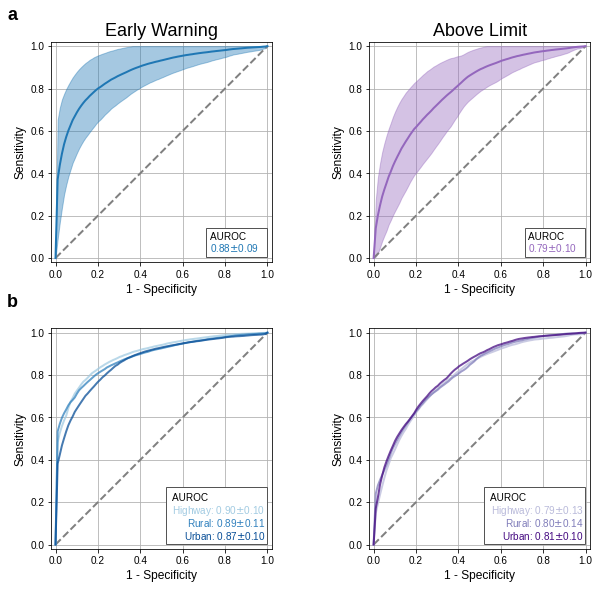

In [18]:
env_position_text = {"highway": 0.55, "rural": 0.615, "town": 0.6}
plot_roc(results)

In [19]:
def plot_coefs_by_group(results, title="", keep_top=3, rename=True):
    fig = plt.figure(figsize=(11, 10.5))
    overall_grid = gridspec.GridSpec(2, 1, height_ratios=[1, 6], hspace=0.3)
    
    df_per_model = {}
    for column, model in enumerate(models):
        list_coef = []
        features = None
        coefs = results[model]["coefs"]
        for key in coefs:
            if features is None:
                features = coefs[key]["Feature"]
            list_coef.append(coefs[key]["Coefficients"])
        df_coefs = pd.DataFrame(data=np.array(list_coef), columns=features).melt()
        df_coefs['abs_value'] = df_coefs.value.abs()
        df_per_model[model] = df_coefs
    
    grid_feature_summary = gridspec.GridSpecFromSubplotSpec(1, len(models), subplot_spec=overall_grid[0], wspace=0.7, hspace=0.5)
    for column, model in enumerate(models):
        ax = fig.add_subplot(grid_feature_summary[column])
        df_coefs = df_per_model[model]

        df_coefs_grouped = df_coefs.groupby('Feature').agg('mean')
        df_coefs_grouped_percentage = df_coefs_grouped[["value", "abs_value"]] / df_coefs_grouped["abs_value"].sum() * 100

        df_coefs_grouped_percentage = df_coefs_grouped_percentage.reset_index()
        df_coefs_grouped_percentage["Feature"] = df_coefs_grouped_percentage["Feature"].astype("string")
        df_coefs_grouped_percentage['Feature'] = df_coefs_grouped_percentage['Feature'].map(lambda x: FEATURE_GROUP_MATCHER[x.split("+")[0]])
        df_coefs_grouped_percentage = df_coefs_grouped_percentage.groupby(["Feature"]).sum().reset_index()
        df_coefs_grouped_percentage = df_coefs_grouped_percentage.sort_values(by='abs_value', ascending=False)
        top_feat_list = list(df_coefs_grouped_percentage.index)

        def sorter(column):
            reorder = FEATURE_GROUPS
            cat = pd.Categorical(column, categories=reorder, ordered=True)
            return pd.Series(cat)

        #df_coefs_grouped_percentage = df_coefs_grouped_percentage.sort_values(by="Feature", key=sorter)
                
        df_coefs_grouped_percentage = df_coefs_grouped_percentage.sort_values(by='Feature', key=sorter)
        
        print(df_coefs_grouped_percentage)

        ax.axvline(x=0, color="#999999", linewidth=1, zorder=-1)
        ax.set_xlim([0, 100])
        #ax.set_xticks([-4.0, -3.5, -3, -2.5, -2.0, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2.0, 2.5, 3, 3.5, 4.0])
        #ax.set_xticklabels(['-4.0', -3.5, -3, -2.5, -2.0, -1.5, -1, -0.5, 0.0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, '4.0'])

        sns.barplot(y=df_coefs_grouped_percentage['Feature'], x=df_coefs_grouped_percentage['abs_value'], orient="h",ax=ax,
                    #order=top_feat_list,
                    #palette=np.array(pal[::-1])[rank]
                    color=model_colors[model],
                    #inner="stick"
                    #fliersize=0,
                    zorder=100,
                    linewidth=1
                    #width=0.8
                    )
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        for coef in df_coefs_grouped_percentage['Feature']:
            ax.axhline(y=coef, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-100)
        ax.grid(axis='y')
        #ax.set_title(f"{model}")
        ax.set_xlabel('% of absolute sum of all coefficients')
        #ax.yaxis.set_label_coords(-0.6, 0.5)
        if column == 0:
            ax.set_ylabel("Feature group")
            ax.yaxis.set_label_coords(-0.62, 0.5)
        else:
            ax.set_ylabel("")
        #ax.yaxis.labelpad = 10

        if column == 0:
            ax.text(-0.85, 1.3, 'a', transform=ax.transAxes, fontsize='18', weight='bold', clip_on=False)
            
        ax.set_title(f"{model}", pad=20)

    
    grid_feature_groups = gridspec.GridSpecFromSubplotSpec(3, len(models), subplot_spec=overall_grid[1], wspace=0.8)
    for row, feature_group in enumerate(FEATURE_GROUPS):
        for column, model in enumerate(models):
            ax = fig.add_subplot(grid_feature_groups[row, column])
            
            df_coefs = df_per_model[model]
            max_value = round(df_coefs['abs_value'].max())
            
            df_coefs_fg = df_coefs[df_coefs['Feature'].str.contains('|'.join(FEATURES_IN_FEATURE_GROUP[feature_group]))]

            df_coefs_grouped = df_coefs_fg.groupby('Feature').agg('mean')
            df_coefs_grouped = df_coefs_grouped.sort_values(by='abs_value', ascending=False)
            top_feat_list = list(df_coefs_grouped.index)

            def sorter(column):
                reorder = top_feat_list
                cat = pd.Categorical(column, categories=reorder, ordered=True)
                return pd.Series(cat)

            df_coefs_fg = df_coefs_fg.sort_values(by="Feature", key=sorter)

            df_coefs_fg = df_coefs_fg[df_coefs_fg.Feature.isin(top_feat_list[keep_top:]) == False]            

            ax.axvline(x=0, color="#999999", linewidth=1, zorder=-1)
            ax.set_xlim([-max_value, max_value])
            #ax.set_xticks([-4.0, -3.5, -3, -2.5, -2.0, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2.0, 2.5, 3, 3.5, 4.0])
            #ax.set_xticklabels(['-4.0', -3.5, -3, -2.5, -2.0, -1.5, -1, -0.5, 0.0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, '4.0'])
            if rename:
                df_coefs_fg['Feature'] = df_coefs_fg['Feature'].map(FEATURE_DESCRIPTION)
            else:
                print(list(df_coefs_fg['Feature'].unique()))
            sns.stripplot(y='Feature', x='value', data=df_coefs_fg, ax=ax, orient='h',
                        #order=top_feat_list,
                        #palette=np.array(pal[::-1])[rank]
                        color=model_colors[model],
                        edgecolor="black",alpha=.5, s=5,linewidth=0.5
                        #inner="stick"
                        #width=0.8*(len(df_coefs.Feature.unique())/40),
                        #fliersize=0,
                        #zorder=100,
                        #linewidth=1
                        )
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.yaxis.set_ticks_position('none')
            for coef in df_coefs_fg['Feature']:
                ax.axhline(y=coef, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-100)
            ax.grid(axis='y')
            #sns.swarmplot(y='Feature', x='value', size=3, data=df_coefs_fg, ax=ax, orient='h', color=model_colors[model])
            
            #ax.yaxis.set_label_coords(-0.6, 0.5)
            #if row == 0:
                #ax.set_title(f"{model}", pad=20)
            
            if row == 2:
                ax.set_xlabel('Coefficient')
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            else:
                ax.get_xaxis().set_visible(False)
                ax.spines['bottom'].set_visible(False)
            
            #if row > 0:
                #ax.plot([0, 0], [0, -2], color="grey", clip_on=False, linewidth=0.8)
            
            if column == 0:
                ax.set_ylabel(f"{feature_group}\nTop {keep_top} Features")
                ax.yaxis.set_label_coords(-0.65, 0.5)
            else:
                ax.set_ylabel("")
                
            if column == 0 and row == 0:
                ax.text(-0.85, 0.95, 'b', transform=ax.transAxes, fontsize='18', weight='bold', clip_on=False)
            #ax.yaxis.labelpad = 10

    
        #change_width_horizontal(ax, 10)
        
    plt.savefig(f'plots/coefficients.svg', bbox_inches='tight')
    plt.savefig(f'plots/coefficients.pdf', dpi=300, bbox_inches='tight')
    plt.show()

          Feature     value  abs_value
0   Eye movements -0.780725  31.848029
1     Gaze events -4.443907  39.111602
2  Head movements  3.046032  29.040369
          Feature     value  abs_value
0   Eye movements -5.529022  29.230155
1     Gaze events  0.024583  42.653611
2  Head movements -0.076706  28.116234


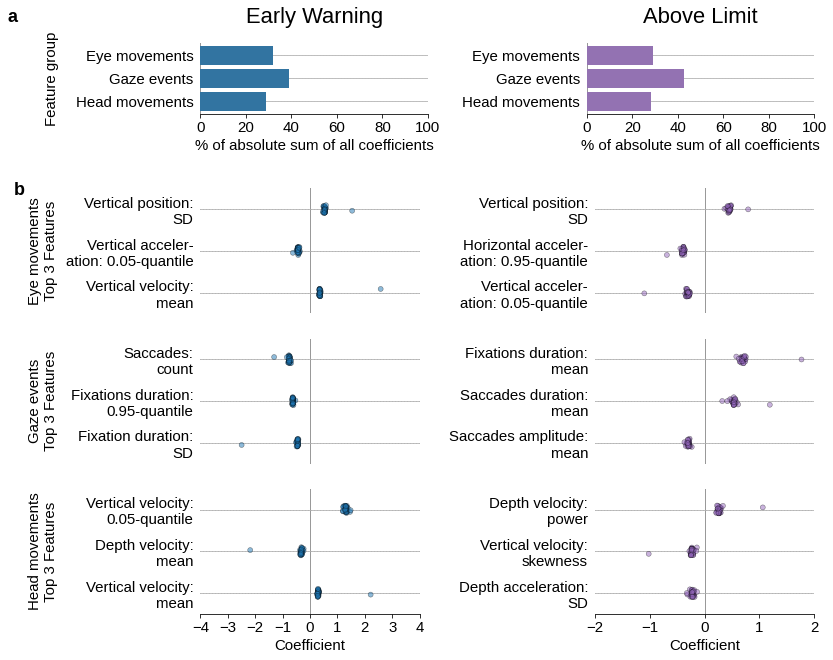

In [20]:
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
FEATURE_GROUPS = ["Eye movements", "Gaze events", "Head movements"]

FEATURE_GROUP_MATCHER = {
    'gaze': 'Eye movements',
    'fixation': 'Gaze events',
    'saccades': 'Gaze events',
    'head': 'Head movements'
}

FEATURES_IN_FEATURE_GROUP = {
    "Eye movements": ["gaze"],
    "Gaze events": ["saccades", "fixation"],
    "Head movements": ["head"]
}

matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

FEATURE_DESCRIPTION = {'gaze+std_y': "Vertical position:\nSD",
'gaze+q5_a_y': "Vertical acceler-\nation: 0.05-quantile",
'gaze+q95_a_x_y': "Acceleration:\n0.95-quantile",
'gaze+std_v_y': 'Vertical\nvelocity: SD',
'gaze+q95_a_x': 'Horizontal acceler-\nation: 0.95-quantile',
'saccades+mean_peak_vel': 'Saccades peak\nvelocities: mean',
'fixation+count': 'Fixations:\ncount',
'saccades+count': 'Saccades:\ncount',
'fixation+skewness_duration': 'Fixations duration:\nskewness',
'fixation+q95_duration': 'Fixations duration:\n0.95-quantile',
'fixation+mean_duration': 'Fixations duration:\nmean',
'fixation+skewness_avg_vel': 'Fixations mean\nvelocities: skewness',
'fixation+kurtosis_avg_vel': 'Fixations mean\nvelocities: kurtosis',
'head+q5_v_head_y': 'Vertical velocity:\n0.05-quantile',
'head+mean_v_head_z': 'Depth velocity:\nmean',
'head+std_a_head_z': 'Depth acceleration:\nSD',
'head+std_v_head_x_y_z': 'Combined velocity:\nSD',
'head+kurtosis_v_head_z': 'Depth\nvelocity: kurtosis',
'head+power_a_head_y': 'Vertical\nacceleration: power',
'head+kurtosis_a_head_y': 'Vertical acceleration:\nkurtosis',
                      'head+mean_a_head_x_y_z': 'Combined acceleration:\n mean',
                      'head+std_v_head_y': 'Vertical velocity:\nSD',
                      'head+power_v_head_z': 'Depth velocity:\npower',
                      'saccades+mean_avg_vel': 'Saccades mean\nvelocities: mean',
                      'saccades+mean_peak_vel': 'Saccades peak\nvelocities: mean',
                      'gaze+std_x': 'Horizontal position:\nSD',
                      'gaze+power_y': 'Vertical position:\npower',
                      'gaze+q5_a_x': 'Horizontal acceler-\nation: 0.05-quantile',
                      'gaze+kurtosis_a_x_y': 'Combined acceler-\nation: kurtosis',
                      "fixation+std_duration": "Fixation duration:\nSD",
                      'gaze+mean_v_y': "Vertical velocity:\nmean",
                      'saccades+mean_duration': 'Saccades duration:\nmean',
                      'saccades+mean_amp': 'Saccades amplitude:\nmean',
                      'head+skewness_v_head_y': 'Vertical velocity:\nskewness',
                      'head+mean_v_head_y': 'Vertical velocity:\nmean'}

plot_coefs_by_group(results, rename=True)

In [21]:
def plot_confusion_matrix(ax, y_true, y_pred, title, color_gradient, y_orig=None, handle_below="sober"):
    if y_orig is None:
        match_x_labels = {0: "no alcohol", 1: "severe"}
        match_label_state_confusion = match_x_labels
    else:
        if handle_below == "sober":
            match_x_labels = {0: "no alcohol\n+\nmoderate", 1: "severe"}
            match_label_state_confusion = {0: "no alcohol", 1: "moderate", 2: "severe"}
        else:
            match_x_labels = {0: "no alcohol", 1: "moderate\n+\nsevere"}
            match_label_state_confusion = {0: "no alcohol", 1: "moderate", 2: "severe"}

    if y_orig is None:
        y = y_true
    else:
        y = y_orig
    df = pd.DataFrame(list(zip(y, y_pred)), columns=['y', 'y_pred'])

    normalize_mode = "columns"
    df_confusion = pd.crosstab(df['y_pred'], df['y'], colnames=['Predicted'], rownames=['True'],
                               normalize=normalize_mode)
    
    
    df_simpler = pd.DataFrame(list(zip(y_true, y_pred)), columns=['y', 'y_pred'])
    df_confusion_simpler = pd.crosstab(df_simpler['y_pred'], df_simpler['y'], colnames=['Predicted'], rownames=['True'],
                               normalize=normalize_mode)
    print(df_confusion_simpler)

    def replace_names(df):
        df = df.set_index(df.index.to_series().replace(match_x_labels))
        df = df.rename(columns=match_label_state_confusion)
        return df

    df_confusion = replace_names(df_confusion)

    if y_orig is None:
        group_names = ['(TN)', '(FN)', '(FP)', '(TP)']
        group_percentages = ['{:.2f}'.format(value) for value in df_confusion.to_numpy().flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, group_names)]
        labels = np.asarray(labels).reshape(2, 2)
    else:
        if handle_below == "sober":
            group_names = ['(TN)', '(TN)', '(FN)', '(FP)', '(FP)', '(TP)']
        else:
            group_names = ['(TN)', '(FN)', '(FN)', '(FP)', '(TP)', '(TP)']
        group_percentages = ['{:.2f}'.format(value) for value in df_confusion.to_numpy().flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, group_names)]
        labels = np.asarray(labels).reshape(2, 3)

    sns.heatmap(df_confusion, ax=ax, annot=labels, cmap=color_gradient, cbar=None, fmt="")

    ax.set_title(title, pad=32)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.yaxis.set_label_coords(-0.22, 0.5)
    
    
    labels_text = ax.get_yticklabels()
    for label_text in labels_text:
        if "+" in label_text.get_text():
            ax.text(-0.35, label_text.get_position()[1], label_text.get_text(), horizontalalignment='center', verticalalignment='center', rotation=90, size=14)
        else:
            ax.text(-0.15, label_text.get_position()[1], label_text.get_text(), horizontalalignment='center', verticalalignment='center', rotation=90, size=14)
    ax.set_yticklabels([])

    if y_orig is None:
        ax.axvline(1, color="black", linewidth=2, ymin=-0.05, ymax=1.05, clip_on=False, linestyle="--")
    else:
        if handle_below !="sober":
            ax.axvline(1, color="black", linewidth=2, ymin=-0.05, ymax=1.05, clip_on=False, linestyle="--")
            ax.text(0.5, -0.1, s="no alcohol", size=14, ha="center", va="center")
            ax.axvline(0.5, color="black", linewidth=0.5, ymin=1, ymax=1.02, clip_on=False)
            ax.text(2, -0.1, s="moderate + severe", size=14, ha="center", va="center")
            ax.axvline(2, color="black", linewidth=0.5, ymin=1, ymax=1.02, clip_on=False)
        else:
            ax.axvline(2, color="black", linewidth=2, ymin=-0.05, ymax=1.05, clip_on=False, linestyle="--")
            ax.text(1, -0.1, s="no alcohol + moderate", size=14, ha="center", va="center")
            ax.axvline(1, color="black", linewidth=0.5, ymin=1, ymax=1.02, clip_on=False)
            ax.text(2.5, -0.1, s="severe", size=14, ha="center", va="center")
            ax.axvline(2.5, color="black", linewidth=0.5, ymin=1, ymax=1.02, clip_on=False)

    return ax

Predicted       0.0       1.0
True                         
0          0.764366  0.252048
1          0.235634  0.747952
Predicted       0.0       1.0
True                         
0          0.713853  0.353791
1          0.286147  0.646209


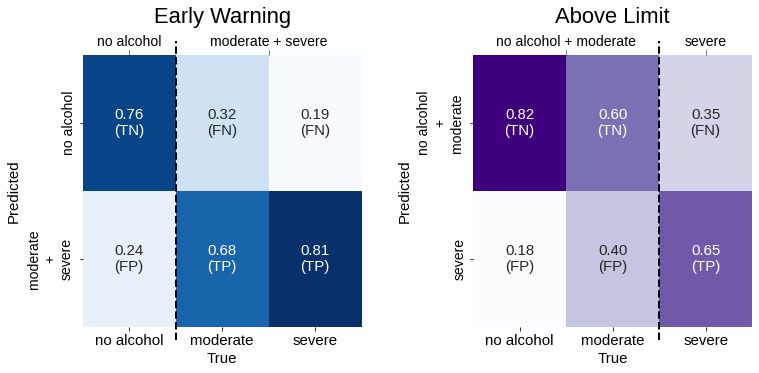

In [22]:
cmaps = {'Early Warning': 'Blues' ,
        'Above Limit': 'Purples'}

fig, axs = plt.subplots(1, len(models), figsize=(12, 5))
for col, model in enumerate(models):    
    if model == "Above Limit":
        plot_confusion_matrix(axs[col], results[model]["y_true"], results[model]["y_pred"], model, cmaps[model], y_orig=results[model]["y_orig"])
    else:
        plot_confusion_matrix(axs[col], results[model]["y_true"], results[model]["y_pred"], model, cmaps[model], y_orig=results[model]["y_orig"], handle_below="high")

fig.subplots_adjust(wspace=0.4)

plt.savefig(f'plots/confusionmatrix.svg', bbox_inches='tight')
plt.savefig(f'plots/confusionmatrix.pdf', dpi=300, bbox_inches='tight')
plt.show()